<a href="https://colab.research.google.com/github/jtsuihk/Assessments/blob/main/Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
df_original = pd.read_csv('/content/Project.csv',encoding="ISO-8859-1")

In [3]:
df_original['InvoiceDate'] = pd.to_datetime(df_original['InvoiceDate'])

In [4]:
df_original.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df_original.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
df_original.isnull().sum().sum()

136534

In [7]:
df_original.dropna(inplace=True)

In [8]:
df_original.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df_original.duplicated().sum()

5225

In [10]:
df_original.drop_duplicates(inplace = True)

Text(0, 0.5, 'Countries')

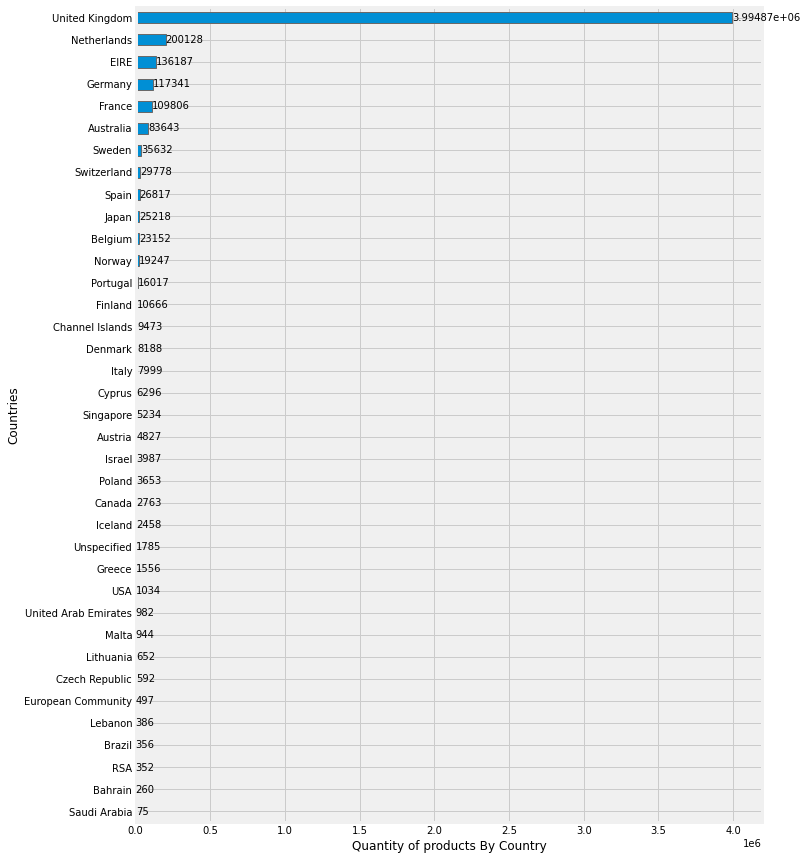

In [11]:
x_q = df_original.groupby(['Country'])['Quantity'].sum()
x_qs = x_q.sort_values()

ax = x_qs.plot.barh(figsize=(10,15))
ax.bar_label(ax.containers[0])
ax.set_xlabel("Quantity of products By Country")
ax.set_ylabel("Countries")


In [12]:
cc = df_original[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
cc = cc.reset_index(drop=False)
total = cc['Country'].value_counts()
total.columns=['Countries','Total Orders']


In [13]:
len(total)

37

Text(0, 0.5, 'Countries')

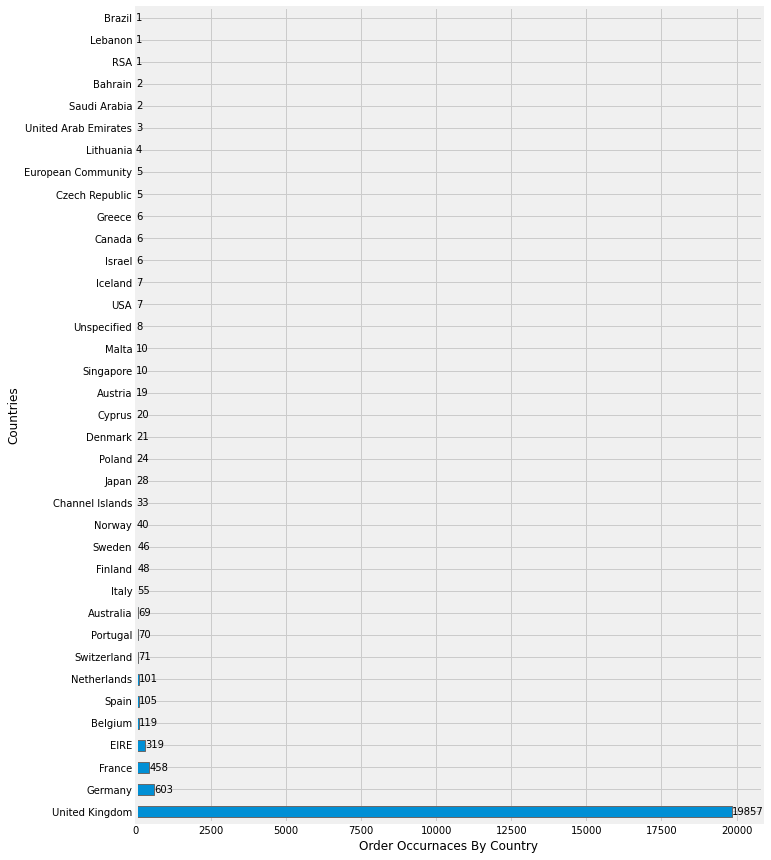

In [14]:
ax = total.plot.barh(figsize=(10,15))
ax.bar_label(ax.containers[0])
ax.set_xlabel("Order Occurnaces By Country")
ax.set_ylabel("Countries")

In [15]:
pd.DataFrame([{'Products': len(df_original['StockCode'].value_counts()),
'Transactions': len(df_original['InvoiceNo'].value_counts()),
'Customers': len(df_original['CustomerID'].value_counts()),}], 
columns = ['Products', 'Transactions', 'Customers'], index = ['Quantity'])

,Products,Transactions,Customers
Quantity,3684,22190,4372


In [16]:
a = df_original.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
products_purchased = a.rename(columns = {'InvoiceDate':'Number of products'})
products_purchased[:10]

products_purchased['order_cancelled'] = products_purchased['InvoiceNo'].apply(lambda x:int('C' in x))
display(products_purchased[:10])

num1 = products_purchased['order_cancelled'].sum()
num2 = products_purchased.shape[0]
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(num1, num2, num1/num2*100))

,CustomerID,InvoiceNo,Number of products,order_cancelled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0
5,12347.0,556201,18,0
6,12347.0,562032,22,0
7,12347.0,573511,47,0
8,12347.0,581180,11,0
9,12348.0,539318,17,0


Number of orders cancelled: 3654/22190 (16.47%) 


In [17]:
df_examine = df_original[df_original['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
df_examine

,CustomerID,Quantity,StockCode,Description,UnitPrice
141,14527.0,-1,D,Discount,27.50
154,15311.0,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548.0,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548.0,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548.0,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29
...,...,...,...,...,...
540449,14397.0,-11,23144,ZINC T-LIGHT HOLDER STARS SMALL,0.83
541541,15498.0,-1,M,Manual,224.69
541715,15311.0,-5,21258,VICTORIAN SEWING BOX LARGE,10.95
541716,17315.0,-1,84978,HANGING HEART JAR T-LIGHT HOLDER,1.25


In [18]:
for index, col in  df_examine.iterrows():
  if df_original[(df_original['CustomerID'] == col[0]) & (df_original['Quantity'] == -col[1]) & (df_original['Description'] == col[2])].shape[0] == 0: 
        print(df_original.loc[index])
        break

InvoiceNo                  C536379
StockCode                        D
Description               Discount
Quantity                        -1
InvoiceDate    2010-12-01 09:41:00
UnitPrice                     27.5
CustomerID                 14527.0
Country             United Kingdom
Name: 141, dtype: object


In [19]:
df_examine = df_original[(df_original['Description'] != 'Discount') & (df_original['Quantity'] < 0)][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
for index, col in  df_examine.iterrows():
  if df_original[(df_original['CustomerID'] == col[0]) & (df_original['Quantity'] == -col[1]) & (df_original['Description'] == col[2])].shape[0] == 0: 
        print(df_original.loc[index])
        break


InvoiceNo                              C536383
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
Quantity                                    -1
InvoiceDate                2010-12-01 09:49:00
UnitPrice                                 4.65
CustomerID                             15311.0
Country                         United Kingdom
Name: 154, dtype: object


In [20]:
df_clean = df_original.copy(deep = True)
df_clean['QuantityCancelled'] = 0

entry_drop = [] ; entry_doubtful = []

for index, col in  df_original.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_original[(df_original['CustomerID'] == col['CustomerID']) & (df_original['StockCode']  == col['StockCode']) & (df_original['InvoiceDate'] < col['InvoiceDate']) & (df_original['Quantity']   > 0)].copy()

    if (df_test.shape[0] == 0): 
        entry_doubtful.append(index)

    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_clean.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        entry_drop.append(index)

    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_clean.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            entry_drop.append(index) 
            break      

In [21]:
print("Entries to be removed: ", len(entry_drop))
print("doubtfull_entry: " , len(entry_doubtful))

Entries to be removed:  7521
doubtfull_entry:  1226


In [22]:
df_clean.drop(entry_drop, axis = 0, inplace = True)
df_clean.drop(entry_doubtful, axis = 0, inplace = True)
remain_to_delete = df_clean[(df_clean['Quantity'] < 0) & (df_clean['StockCode'] != 'D')]

In [23]:
remain_to_delete[:10]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358.0,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422.0,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754.0,United Kingdom,0
197417,C553904,22897,OVEN MITT APPLES DESIGN,-11,2011-05-19 18:10:00,1.45,13081.0,United Kingdom,0
213271,C555529,22698,PINK REGENCY TEACUP AND SAUCER,-24,2011-06-05 11:45:00,2.95,16923.0,United Kingdom,0
240687,C558110,22423,REGENCY CAKESTAND 3 TIER,-4,2011-06-26 15:47:00,12.75,17731.0,United Kingdom,0
273711,C560855,22262,FELT EGG COSY CHICKEN,-4,2011-07-21 13:00:00,0.85,14410.0,United Kingdom,0
288593,C562188,85099B,JUMBO BAG RED RETROSPOT,-100,2011-08-03 12:16:00,1.79,12748.0,United Kingdom,0


In [24]:
df_clean[(df_clean['StockCode'] == '22464') & (df_clean['CustomerID'] == 14048)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled
84247,543371,22464,HANGING METAL HEART LANTERN,3,2011-02-07 14:53:00,1.65,14048.0,United Kingdom,0
84259,543371,22464,HANGING METAL HEART LANTERN,1,2011-02-07 14:53:00,1.65,14048.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,0


In [25]:
df_clean[((df_clean['StockCode'] == '22784') & df_clean['CustomerID'] == 14659)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled


In [26]:
list_stock_codes = df_clean[df_clean['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_stock_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [27]:
for code in list_stock_codes:
    print("{:<15} -> {:<30}".format(code, df_clean[df_clean['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


In [28]:
for code in list_stock_codes:
  print(code,'----',df_clean[df_clean['StockCode'] == code]['Description'].unique()[0])

POST ---- POSTAGE
D ---- Discount
C2 ---- CARRIAGE
M ---- Manual
BANK CHARGES ---- Bank Charges
PADS ---- PADS TO MATCH ALL CUSHIONS
DOT ---- DOTCOM POSTAGE


In [29]:
#Basket Amount in money terms

In [30]:
#Total price of each transaction

df_clean['TotalPrice'] = df_clean['UnitPrice'] * (df_clean['Quantity'] - df_clean['QuantityCancelled'])
df_clean.sort_values('CustomerID')[:10]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347.0,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347.0,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347.0,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347.0,Iceland,0,35.7
428968,573511,47580,TEA TIME DES TEA COSY,6,2011-10-31 12:25:00,2.55,12347.0,Iceland,0,15.3
428967,573511,23173,REGENCY TEAPOT ROSES,2,2011-10-31 12:25:00,9.95,12347.0,Iceland,0,19.9
428966,573511,22423,REGENCY CAKESTAND 3 TIER,6,2011-10-31 12:25:00,12.75,12347.0,Iceland,0,76.5
428965,573511,22945,CHRISTMAS METAL TAGS ASSORTED,12,2011-10-31 12:25:00,0.85,12347.0,Iceland,0,10.2
428964,573511,22252,BIRDCAGE DECORATION TEALIGHT HOLDER,12,2011-10-31 12:25:00,1.25,12347.0,Iceland,0,15.0


In [33]:
info = df_clean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket = info.rename(columns = {'TotalPrice':'Basket Price'})

df_clean['InvoiceDate_int'] = df_clean['InvoiceDate'].astype('int64')
info = df_clean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_clean.drop('InvoiceDate_int', axis = 1, inplace = True)
basket.loc[:, 'InvoiceDate'] = pd.to_datetime(info['InvoiceDate_int'])

basket = basket[basket['Basket Price'] > 0]
basket.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347.0,537626,711.79,2010-12-07 14:57:00.000000000
2,12347.0,542237,475.39,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,2011-04-07 10:43:00.000000000
4,12347.0,556201,382.52,2011-06-09 13:01:00.000000000
5,12347.0,562032,584.91,2011-08-02 08:48:00.000000000
6,12347.0,573511,1294.32,2011-10-31 12:25:00.000000000


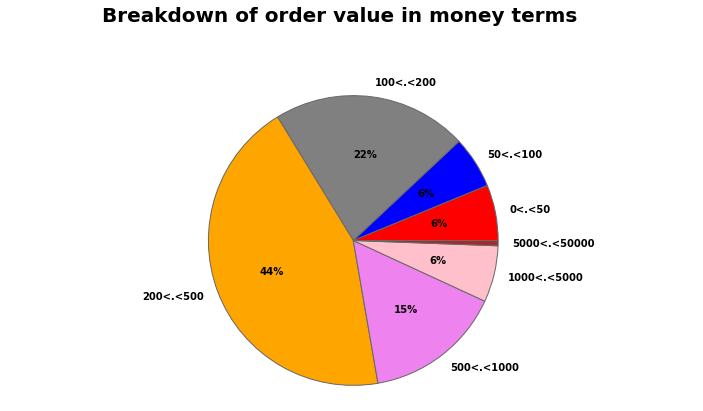

In [41]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket[(basket['Basket Price'] < price) & (basket['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
     
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['red', 'blue', 'grey', 'orange', 'violet', 'pink','brown']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Breakdown of order value in money terms", ha='center', fontsize = 20);

In [43]:
#Insight for categories of products

In [42]:
import nltk
nltk.download('punkt')

from nltk import pos_tag, word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [44]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inv(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  
    keywords_select = dict()  
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [45]:
df_products = pd.DataFrame(df_original['Description'].unique()).rename(columns = {0:'Description'})
category_keys, keywords_roots, keywords_select, count_keywords = keywords_inv(df_products)

Nb of keywords in variable 'Description': 1483


In [46]:
products_lst = []
for k,v in count_keywords.items():
    products_lst.append([keywords_select[k],v])
products_lst.sort(key = lambda x:x[1], reverse = True)

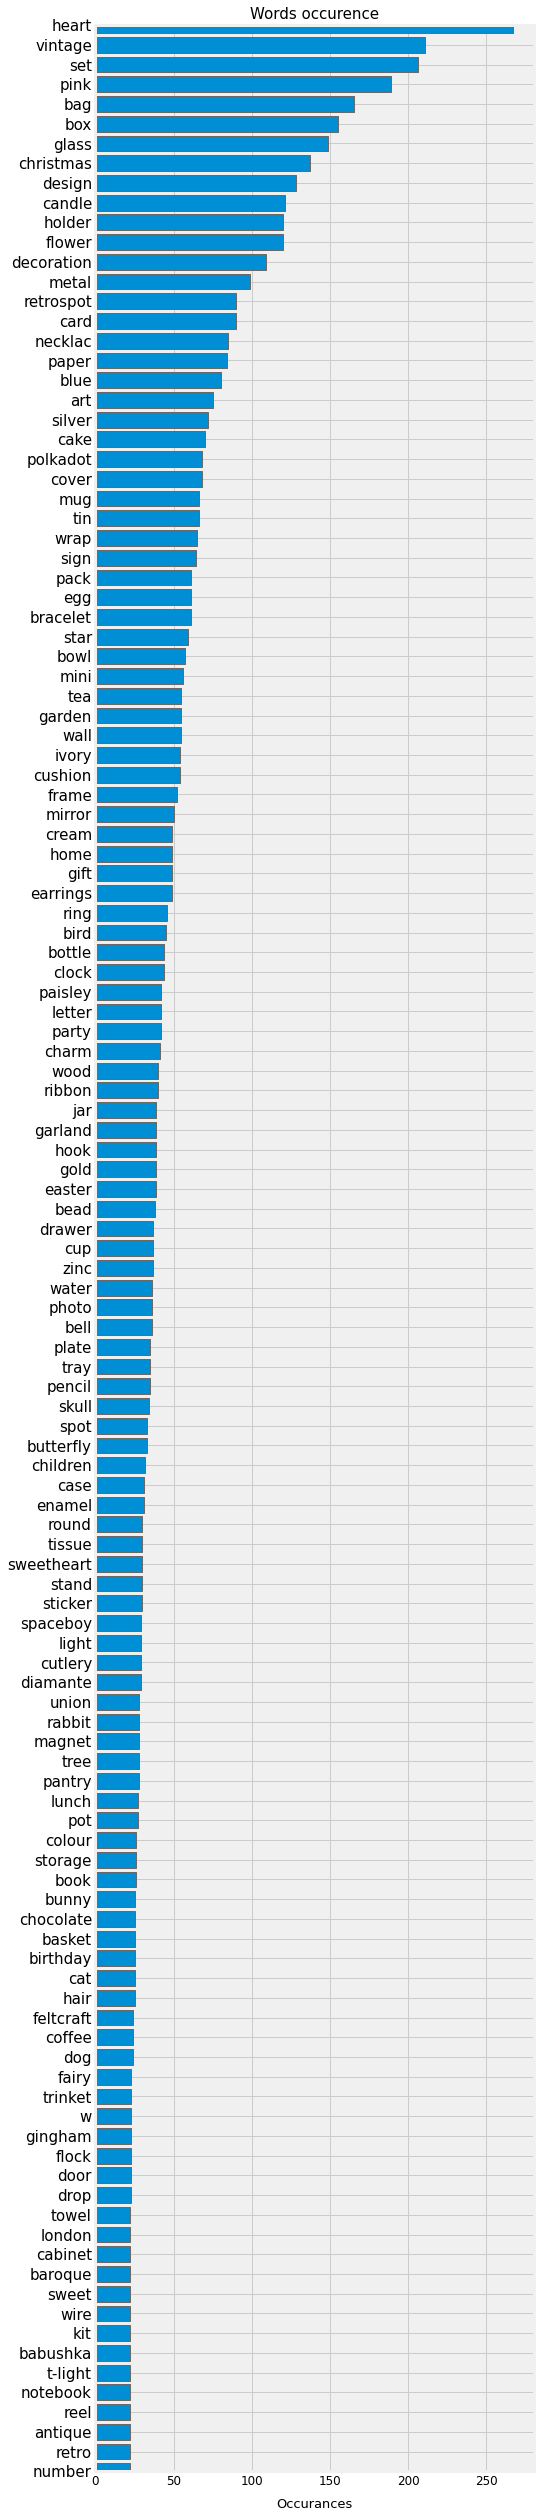

In [48]:
lst = sorted(products_lst, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 45))
y_axis = [i[1] for i in lst[:125]]
x_axis = [k for k,i in enumerate(lst[:125])]
x_label = [i[0] for i in lst[:125]]
y_label = ['Key Words']
plt.ylim(bottom=0)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.yticks(x_axis, x_label)
plt.xlabel("Occurances", fontsize = 13, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",fontsize = 15)
plt.show()

In [49]:
#Catagorizing products

In [50]:
#Remove words that carries no info e.g. color
products_lst = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue',  'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 15: continue
    if ('+' in word) or ('/' in word): continue
    products_lst.append([word, v])
   
products_lst.sort(key = lambda x:x[1], reverse = True)
print('Number of keywords:', len(products_lst))

Number of keywords: 168


In [51]:
#Data encoding

In [52]:
lst_products_ec = df_clean['Description'].unique()
X = pd.DataFrame()
for key in lst_products_ec:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), lst_products_ec))
for occurence in lst_products_ec:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), lst_products_ec))

In [53]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(lst_products_ec):
    prix = df_clean[ df_clean['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [54]:
print('Range', '     ' , 'Amount of Products')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Range       Amount of Products
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


In [55]:
#Cluster of products

In [56]:
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    clusters = kmeans.fit_predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.1898606693276738
For n_clusters = 4 The average silhouette_score is : 0.23552300068988366
For n_clusters = 5 The average silhouette_score is : 0.2729690432305675
For n_clusters = 6 The average silhouette_score is : 0.2892909427660495
For n_clusters = 7 The average silhouette_score is : 0.25960903316821726
For n_clusters = 8 The average silhouette_score is : 0.1658730831832714
For n_clusters = 9 The average silhouette_score is : 0.19660905090963793


In [57]:
#Use 5 clusters as score becoming less related

In [58]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.27:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.2729690432305675


In [59]:
pd.Series(clusters).value_counts()

1    1009
3     964
4     673
0     626
2     606
dtype: int64

In [60]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        y_lower = y_upper + 10  

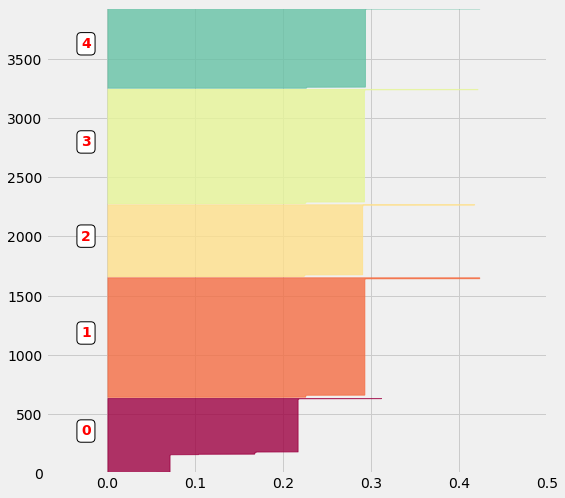

In [61]:
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.5], len(X), sample_silhouette_values, clusters)

In [62]:
lst = pd.DataFrame(lst_products_ec)
lst_words = [word for (word, occurence) in products_lst]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    lst_cluster = lst.loc[clusters == i]
    for word in lst_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(lst_cluster.loc[:, 0].str.contains(word.upper()))

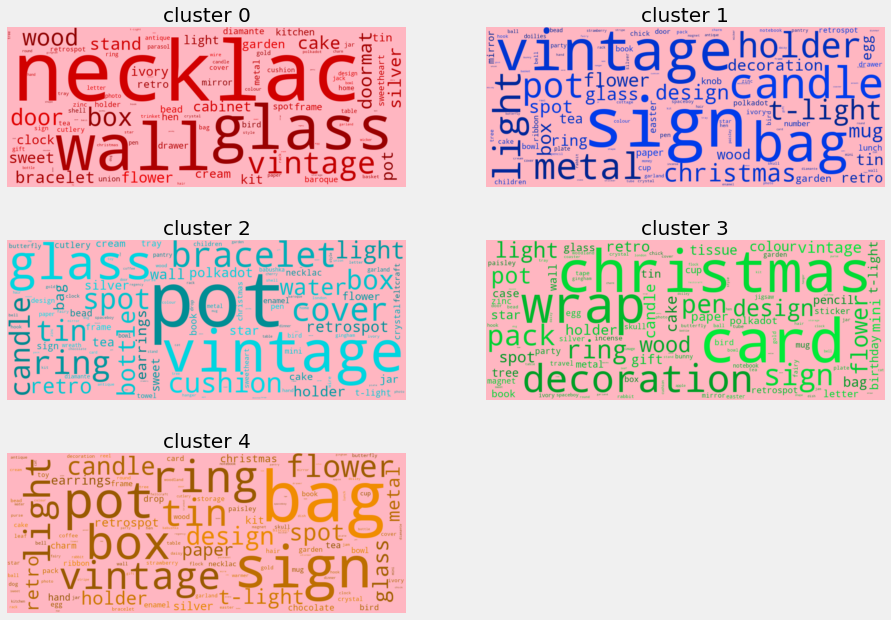

In [63]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    wordcloud = WordCloud(width=1000,height=400, background_color='lightpink', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster {}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    lst_cluster_occurences = occurence[i]

    tone = color[i] 
    lst = []
    for key, value in lst_cluster_occurences.items():
        lst.append([key, value])
    lst.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(lst, i+1)            

In [64]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

In [65]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

In [66]:
import matplotlib.patches as mpatches

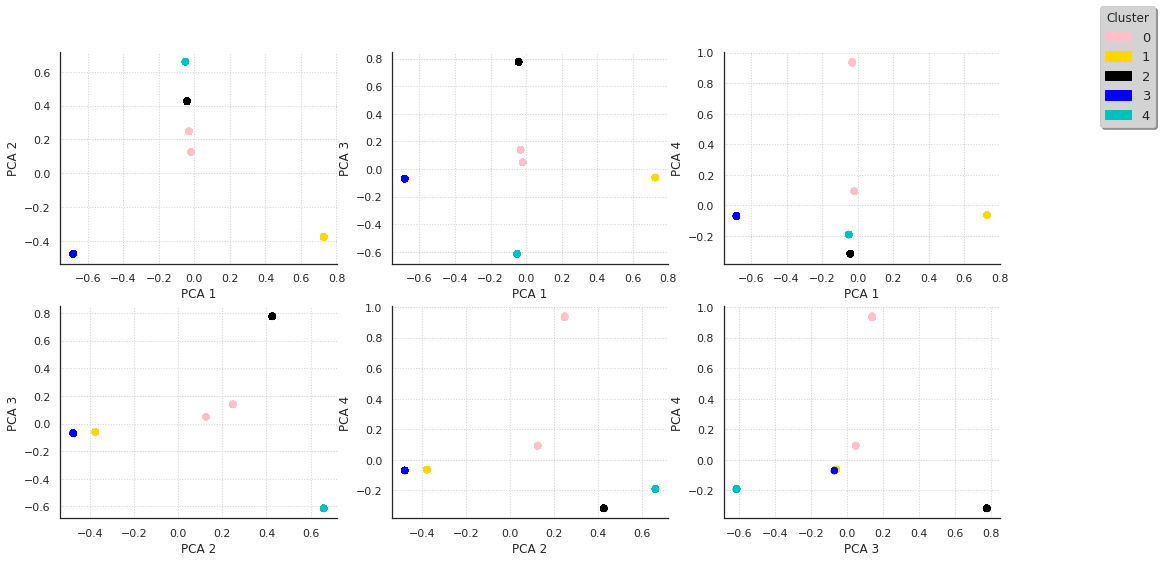

In [69]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'pink', 1:'gold', 2:'black', 3:'blue', 4:'c', 5:'green'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
comp_handler = []      
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

In [70]:
corresp = dict()
for key, val in zip (lst_products_ec, clusters):
    corresp[key] = val 

df_clean['categ_product'] = df_clean.loc[:, 'Description'].map(corresp)

In [74]:
for i in range(5):
    column = 'categ_{}'.format(i)        
    df_temp = df_clean[df_clean['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCancelled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_clean.loc[:, column] = price_temp
    df_clean[col].fillna(0, inplace = True)

df_clean[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,4,NaN,NaN,NaN,NaN,15.3
1,536365,WHITE METAL LANTERN,2,NaN,NaN,20.34,NaN,NaN
2,536365,CREAM CUPID HEARTS COAT HANGER,2,NaN,NaN,22.00,NaN,NaN
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2,NaN,NaN,20.34,NaN,NaN
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2,NaN,NaN,20.34,NaN,NaN


In [75]:
temp = df_clean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

for i in range(5):
    column = 'categ_{}'.format(i) 
    temp = df_clean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[column].sum()
    basket_price.loc[:, column] = temp[column] 

df_clean['InvoiceDate_int'] = df_clean['InvoiceDate'].astype('int64')
temp = df_clean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_clean.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:10]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347.0,537626,711.79,124.44,187.2,293.35,23.40,83.40,2010-12-07 14:57:00.000000000
2,12347.0,542237,475.39,38.25,130.5,169.20,84.34,53.10,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,38.25,330.9,115.00,81.00,71.10,2011-04-07 10:43:00.000000000
4,12347.0,556201,382.52,19.90,74.4,168.76,41.40,78.06,2011-06-09 13:01:00.000000000
5,12347.0,562032,584.91,136.05,109.7,158.16,61.30,119.70,2011-08-02 08:48:00.000000000
6,12347.0,573511,1294.32,132.10,203.3,368.72,154.30,435.90,2011-10-31 12:25:00.000000000
7,12347.0,581180,224.82,30.00,100.8,0.00,38.58,55.44,2011-12-07 15:52:00.000000000
8,12348.0,539318,892.80,240.00,174.0,0.00,478.80,0.00,2010-12-16 19:09:00.000000000
9,12348.0,541998,227.44,40.00,0.0,0.00,187.44,0.00,2011-01-25 10:42:00.000000000
10,12348.0,548955,367.00,40.00,310.0,0.00,17.00,0.00,2011-04-05 10:47:00.000000000


In [76]:
#Split data according to time period

In [77]:
print(basket_price['InvoiceDate'].min(), '----',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 ---- 2011-12-09 12:50:00


In [78]:
set_entrainement = basket_price[pd.to_datetime(basket_price['InvoiceDate']).dt.date < datetime.date(2011,10,1)] 
set_test = basket_price[pd.to_datetime(basket_price['InvoiceDate']).dt.date >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

In [79]:
#Consumer order habits

In [80]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    column = 'categ_{}'.format(i)
    transactions_per_user.loc[:,column] = basket_price.groupby(by=['CustomerID'])[column].sum()/transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,5,382.52,711.79,558.172000,2790.86,12.787815,29.836681,32.408290,10.442659,14.524555
1,12348.0,4,227.44,892.80,449.310000,1797.24,20.030714,41.953217,0.000000,38.016069,0.000000
2,12350.0,1,334.40,334.40,334.400000,334.40,11.961722,48.444976,0.000000,11.692584,27.900718
3,12352.0,6,144.35,840.30,345.663333,2073.98,67.534402,12.892120,15.711338,0.491808,3.370331
4,12353.0,1,89.00,89.00,89.000000,89.00,67.078652,13.033708,0.000000,0.000000,19.887640


In [81]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:10]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347.0,5,382.52,711.79,558.172000,2790.86,12.787815,29.836681,32.408290,10.442659,14.524555,59,297
1,12348.0,4,227.44,892.80,449.310000,1797.24,20.030714,41.953217,0.000000,38.016069,0.000000,5,288
2,12350.0,1,334.40,334.40,334.400000,334.40,11.961722,48.444976,0.000000,11.692584,27.900718,240,240
3,12352.0,6,144.35,840.30,345.663333,2073.98,67.534402,12.892120,15.711338,0.491808,3.370331,2,226
4,12353.0,1,89.00,89.00,89.000000,89.00,67.078652,13.033708,0.000000,0.000000,19.887640,134,134
5,12354.0,1,1079.40,1079.40,1079.400000,1079.40,23.346304,31.176580,19.700760,14.950899,10.825459,162,162
6,12355.0,1,459.40,459.40,459.400000,459.40,9.882455,53.286896,25.272094,0.000000,11.558555,144,144
7,12356.0,2,481.46,2271.62,1376.540000,2753.08,36.630973,28.656995,7.409883,14.447455,12.854694,175,255
8,12358.0,1,484.86,484.86,484.860000,484.86,82.786784,10.469001,3.093677,0.000000,3.650538,80,80
9,12359.0,3,547.50,1803.11,1153.310000,3459.93,59.748319,9.673606,14.936718,4.227831,11.413526,119,261


In [82]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("Number of clients who only puchase once: ", n1,'/',n2,n1/n2*100,'%')

Number of clients who only puchase once:  1445 / 3608 40.04988913525499 %


In [83]:
list_columns = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_columns].to_numpy()


In [84]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  23.21847344
  25.22916919  16.37327913  13.98907929  21.19884856]


In [85]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

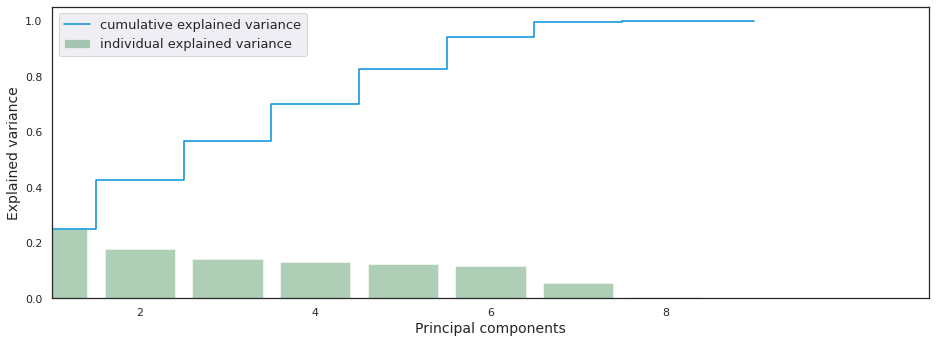

In [86]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

In [89]:
#Creating customer category

In [105]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('Sihoutte Score is : ', silhouette_avg)

Sihoutte Score is :  0.21760728775494317


In [106]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

,9,0,7,4,2,3,1,10,8,5,6
nb. de clients,1459,507,461,293,290,230,186,153,12,10,7


In [107]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

In [108]:
import matplotlib.patches as mpatches

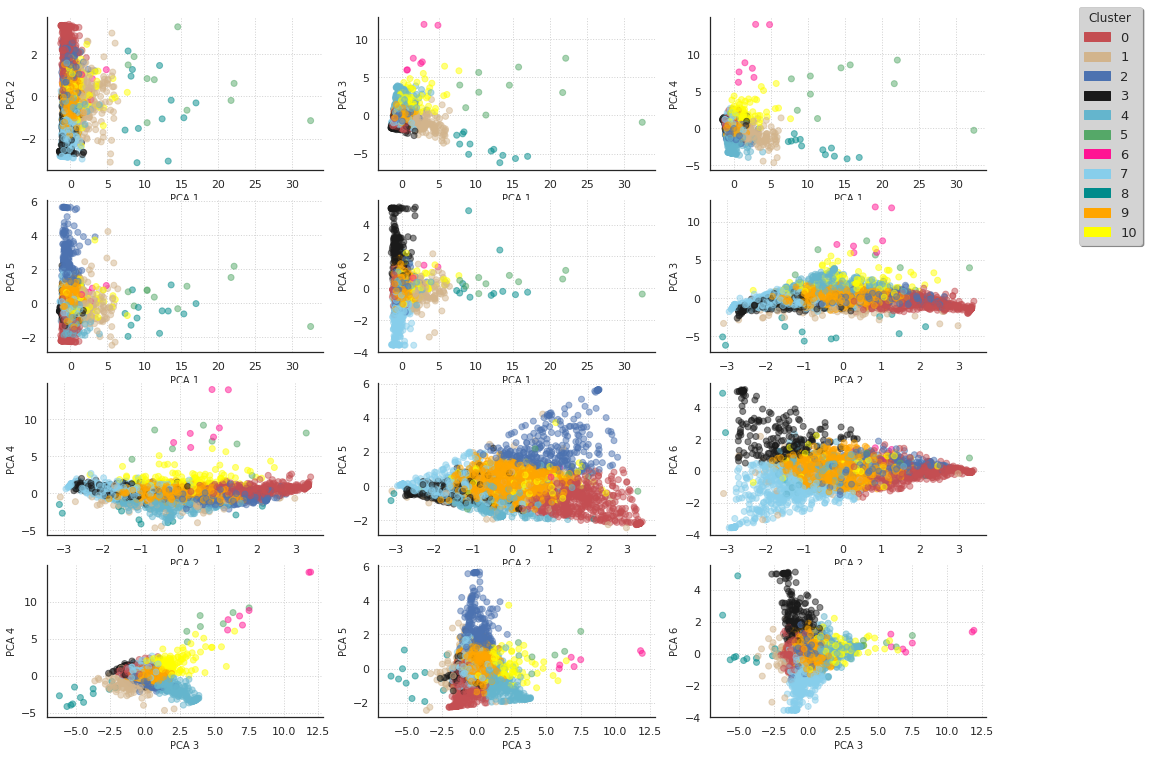

In [109]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,12))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 10)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 10)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

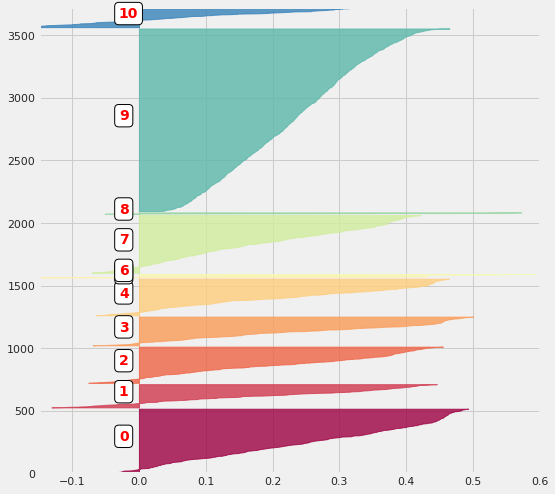

In [112]:
silhouette_visual = silhouette_samples(scaled_matrix, clusters_clients)
silhouette_visual = silhouette_samples(scaled_matrix, clusters_clients)
graph_component_silhouette(n_clusters, [-0.15, 0.6], len(scaled_matrix), silhouette_visual, clusters_clients)

In [113]:
#Customer habits

In [115]:
selected_customers.loc[:, 'cluster'] = clusters_clients

merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


In [118]:
index_lst = []
for i in range(5):
    column = 'categ_{}'.format(i)
    index_lst.append(merged_df[merged_df[column] > 45].index.values[0])

lst_index_reordered = index_lst
lst_index_reordered += [ s for s in merged_df.index if s not in index_lst]

merged_df = merged_df.reindex(index = lst_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,0.0,2.615385,199.178444,344.939921,261.766906,709.984223,62.361851,11.022524,10.976865,4.774153,10.875737,507
1,7.0,2.455531,212.880651,328.933777,267.069554,672.920111,9.516197,57.199382,7.706530,12.761154,12.819967,461
2,2.0,2.131034,202.623310,335.110552,262.189665,649.416207,15.323963,13.455483,51.418763,6.326378,13.528824,290
3,3.0,2.200000,192.353261,314.535652,244.835480,577.950913,7.262276,17.988479,6.021302,57.661137,11.066807,230
4,4.0,2.600683,203.602321,369.633106,282.391041,808.173481,10.351387,14.839907,7.183651,6.921928,60.703127,293
5,9.0,3.247430,219.940042,458.989130,331.191156,1086.179329,20.721504,25.695078,17.450678,14.021344,22.115457,1459
6,1.0,1.672043,1052.877258,1364.247909,1195.116385,2055.397263,22.656593,26.235455,16.951913,12.230337,21.926065,186
7,8.0,1.666667,3480.920833,3966.812500,3700.139306,5949.600000,28.513409,20.102624,15.171169,22.890736,13.322062,12
8,10.0,18.189542,87.112549,1614.723333,578.104549,9964.670915,21.955763,23.987640,16.202149,12.249367,25.625561,153
9,6.0,92.000000,10.985714,1858.250000,374.601553,34845.105714,25.144909,25.832531,13.402971,13.117583,22.527857,7


In [128]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [129]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [130]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)


In [131]:
#SVC Classfier

In [132]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [133]:
svc.grid_fit(X = X_train, Y = Y_train)

In [134]:
svc.grid_predict(X_test, Y_test)

Precision: 80.19 % 


In [ ]:
#Confusion Matrix

In [135]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


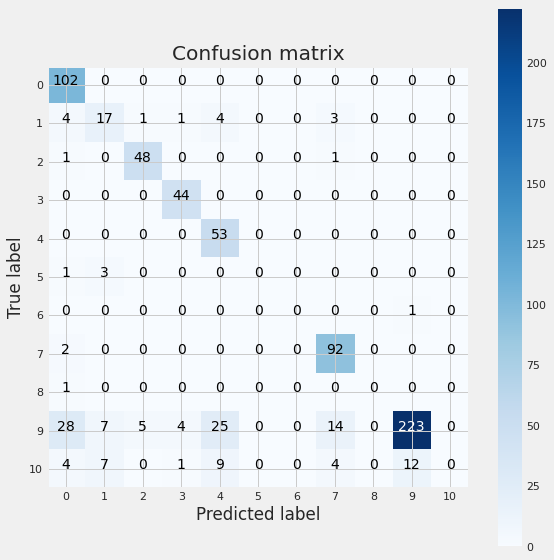

In [136]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

In [137]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

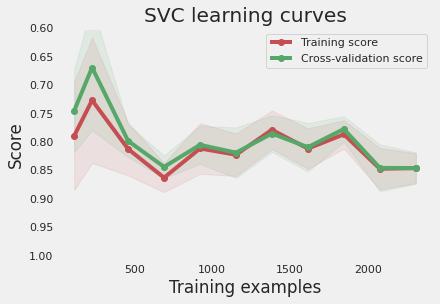

In [139]:
g = plot_learning_curve(svc.grid.best_estimator_,"SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
0.6, 0.7, 0.8, 0.9, 1])

In [144]:
#Logistic Regression

In [140]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 90.03 % 


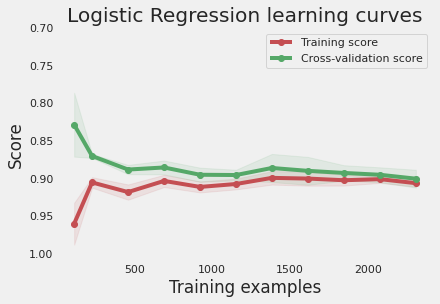

In [141]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train, ylim = [1.01, 0.7], cv = 5, 
train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [145]:
#K-nearest neighbour

In [142]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 80.06 % 


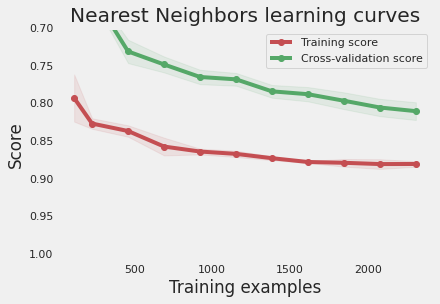

In [143]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,ylim = [1.01, 0.7], cv = 5, 
train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


In [ ]:
#Decision Tree

In [146]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 86.15 % 


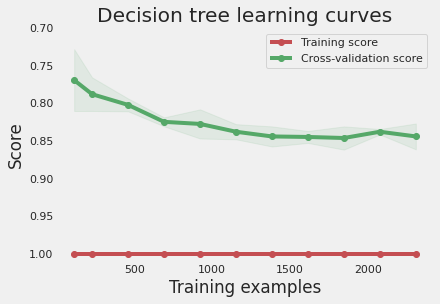

In [147]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,ylim = [1.01, 0.7], cv = 5, 
train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
#Random Forest  

In [148]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 91.00 % 


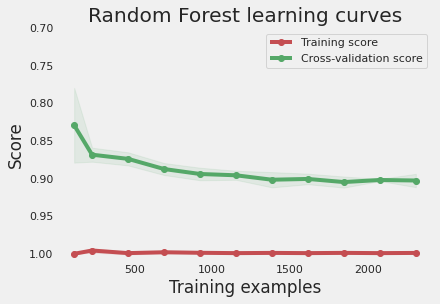

In [149]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,ylim = [1.01, 0.7], cv = 5, 
train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [151]:
#Gradiant Boosting 

In [152]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 89.20 % 


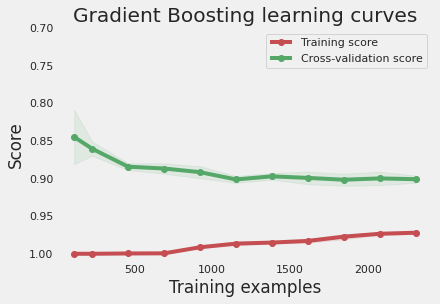

In [153]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,ylim = [1.01, 0.7], cv = 5, 
train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [154]:
#Combine

In [155]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [156]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),('knn', knn_best)], voting='soft')   

In [157]:
votingC = votingC.fit(X_train, Y_train)

In [158]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 89.89 % 


In [159]:
#Testing predictions

In [160]:
basket_price = set_test.copy(deep = True)

In [163]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
    transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:10]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,10,224.82,1294.32,759.570,7595.70,10.670511,20.017905,24.271627,12.696657,32.343299
1,12349.0,5,1757.55,1757.55,1757.550,8787.75,46.021450,26.506216,10.713778,4.513101,12.245455
2,12352.0,5,311.73,311.73,311.730,1558.65,42.953838,34.420813,7.217785,6.672441,8.735123
3,12356.0,5,58.35,58.35,58.350,291.75,100.000000,0.000000,0.000000,0.000000,0.000000
4,12357.0,5,6207.67,6207.67,6207.670,31038.35,33.399810,18.475531,28.350089,5.089832,14.684737
5,12358.0,5,683.20,683.20,683.200,3416.00,96.574941,3.425059,0.000000,0.000000,0.000000
6,12359.0,5,2680.55,2680.55,2680.550,13402.75,51.815859,11.819962,24.155490,0.376042,11.832646
7,12360.0,5,1043.78,1043.78,1043.780,5218.90,22.365824,18.233727,17.431834,13.531587,28.437027
8,12362.0,25,355.80,786.95,520.008,13000.20,27.226504,19.088168,25.143459,5.071460,23.470408
9,12364.0,10,299.06,310.32,304.690,3046.90,12.750665,22.232433,0.000000,62.112311,2.904592


In [165]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

matrix_test = transactions_per_user[list_cols].to_numpy()
scaled_test_matrix = scaler.transform(matrix_test)

In [166]:
Y = kmeans.predict(scaled_test_matrix)

In [167]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

In [170]:
classifiers = [(svc, 'Support Vector Machine'),(lr, 'Logostic Regression'),(knn, 'k-Nearest Neighbors'),(tr, 'Decision Tree'),
                (rf, 'Random Forest'),(gb, 'Gradient Boosting')]

for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 67.07 % 
______________________________ 
Logostic Regression
Precision: 75.50 % 
______________________________ 
k-Nearest Neighbors
Precision: 69.31 % 
______________________________ 
Decision Tree
Precision: 72.72 % 
______________________________ 
Random Forest
Precision: 75.19 % 
______________________________ 
Gradient Boosting
Precision: 75.03 % 
